In [1]:
import holoviews as hv
import geoviews as gv

from bokeh.models import WMTSTileSource
from bokeh.tile_providers import STAMEN_TONER

from cartopy import crs
from cartopy.io.img_tiles import StamenTerrain
# from cartopy import feature as cf
from geoviews import feature as gf
import pandas as pd
import numpy as np

hv.notebook_extension('bokeh','matplotlib')
%output backend='bokeh'

/home/astyonax/.anaconda/lib/python2.7/site-packages/holoviews/core/util.py:27: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  datetime_types = datetime_types + (pd.tslib.Timestamp,)


In [2]:
df = pd.read_pickle('data/traffic_preprocessed.pkl')
# df_inner = pd.read_hdf('data/split_perif_inner.h5','inner')
# df_inner.head()
df.head()

hour  month  id_arc_trafic   AVG(debit)  AVG(taux)  \
id_arc_trafic                                                           
1             0       0      1              1  1188.714286   4.638207   
              93      0      2              1  1261.829268   5.031917   
              186     0      3              1  1468.347826   4.730384   
              79      0      4              1  1106.285714   5.214193   
              165     0      5              1  1452.818182   6.927379   

                         lat       lon   lndebit  time  dlo25  dla25  dlo50  \
id_arc_trafic                                                                 
1             0    48.859838  2.334242  4.121122   100     13     12     25   
              93   48.859838  2.334242  4.170615   200     13     12     25   
              186  48.859838  2.334242  4.298984   300     13     12     25   
              79   48.859838  2.334242  4.062314   400     13     12     25   
              165  48.859838  2.334242  4.289851   500     13     12     25   

                   dla50  dlo75  dla75  
id_arc_trafic                           
1             0       24     38     37  
              93      24     38     37  
              186     24     38     37  
              79      24     38     37  
              165     24     38     37

In [3]:
# df_peri = pd.read_hdf('data/split_perif_inner.h5','periferique')
# df_peri.head()

In [4]:
#coarse graining

def coarse_grain(df):
    df2 = df.groupby(['hour','month','dlo25','dla25']).agg({'AVG(debit)':'sum','AVG(taux)':'mean','lat':'mean','lon':'mean','time':'mean','id_arc_trafic':'max','hour':'mean'})
    df2.columns = df2.columns.get_level_values(0)
    return df2
dfcg = coarse_grain(df)
# dfcg_peri = coarse_grain(df_peri)
# dfcg_inner = coarse_grain(df_inner)
# df2.head()

# or do not coarse grain

dfcg = df

In [5]:
# nodes_inner = dfcg_inner.groupby('time').apply(lambda x:len(x))
# assert(nodes_inner.std()==0.0)
# nodes_peri = dfcg_peri.groupby('time').apply(lambda x:len(x))
# assert(nodes_peri.std()==0.0)
# times =  nodes_inner.shape[0]
# assert(nodes_peri.shape[0]==times)
# nodes_peri = nodes_peri.max()
# nodes_inner = nodes_inner.max()
# data = np.zeros((times,nodes_peri+nodes_inner))

# count = 0

# for inner,peri in zip(dfcg_inner.groupby('time'),dfcg_peri.groupby('time')):
#     assert(inner[0]==peri[0])
#     inner = inner[1]#.sort_values('id_arc_trafic')
#     peri  = peri[1]#.sort_values('id_arc_trafic')
#     data[count,:nodes_inner] = inner['AVG(debit)'].values
#     data[count,nodes_inner:] = peri['AVG(debit)'].values
#     count+=1

In [6]:
nodes = dfcg.groupby('time').apply(lambda x:len(x))
assert(nodes.std()==0.0)
times =  nodes.shape[0]
nodes = nodes.max()
data = np.zeros((times,nodes),dtype=np.float)

count = 0

for inner in dfcg.groupby('time'):
    inner = inner[1]
    data[count] = inner['AVG(debit)'].values
    count+=1

Populating the interactive namespace from numpy and matplotlib


/home/astyonax/.anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['inner']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


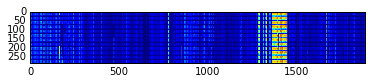

In [7]:
%pylab inline
import pylab as plt
plt.imshow(data)

In [8]:
import pma
def normalize(x):
    x =x.copy()
    mean = x.mean()
    var = x.std()
    x-=mean
    x/=var
    return x,mean,var
data,mean,var = normalize(data)
pma_out = pma.pma(data)

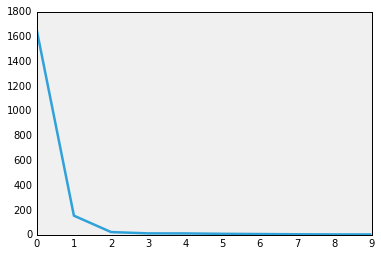

In [9]:
plt.plot(pma_out[0][:10])

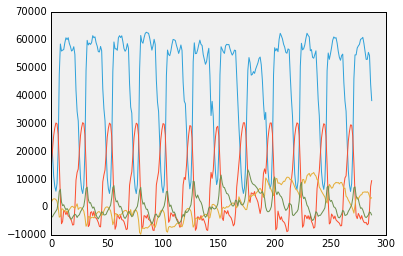

In [10]:
XY = pma.get_XY(data,pma_out[1][:,:4])
for j in XY:
    plt.plot(j*var+mean,lw=1)

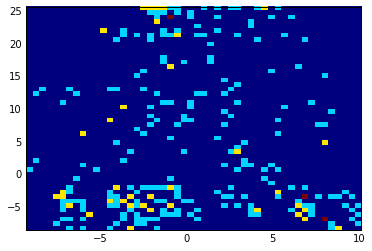

In [11]:
plt.hist2d(XY[2],XY[1],bins=50);

In [12]:
lat = dfcg[dfcg.time==100][['lat']].values
lon = dfcg[dfcg.time==100][['lon']].values

tmp = []
for mode in xrange(5):
    val = pma_out[1][:,mode]
    val = plt.Normalize(vmax=val.mean()+2*val.std(),vmin=val.mean()-2*val.std(),clip=1)(val)
    _tmp = [{'lat':la[0],'lon':lo[0],'val':va,'mode':mode} for la,lo,va in  zip(lat,lon,val)]
    tmp.extend(_tmp)
modes = pd.DataFrame(columns=['lat','lon','val','mode'],data=tmp)

In [13]:
modes.head()

,lat,lon,val,mode
0,48.859838,2.334242,0.691618,0
1,48.859375,2.336451,0.691626,0
2,48.859019,2.339782,0.691626,0
3,48.858747,2.341134,0.691626,0
4,48.858214,2.343447,0.685888,0


## Interactive map

In [14]:
%%output backend='bokeh'
%%opts Overlay [width=int(750) height=int(750) xaxis=None yaxis=None] 
%%opts Points (size=10 cmap='jet') [tools=['hover'] color_index=2 width=int(750) height=int(750) xaxis=None yaxis=None]

pop = gv.Dataset(modes,kdims=['mode',])
counters = pop.to(gv.Points, kdims=['lon', 'lat'],
                    vdims='val', crs=crs.PlateCarree())

gv.WMTS(WMTSTileSource(url='https://maps.wikimedia.org/osm-intl/{Z}/{X}/{Y}@2x.png'),
       crs=crs.epsg(2154)) * counters
# counters


:HoloMap   [mode]
   :Overlay
      .WMTS.I   :WMTS   [Longitude,Latitude]
      .Points.I :Points   [lon,lat]   (val)